In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torchvision
import torch.optim as optim


import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import top_k_accuracy_score


from main import print_test_details, ResNet, BasicBlock, BottleNeck, train_transform, test_transform #custom function in main.py



import json, os

In [2]:
# HYPERPARAMETERS

train_size = 0.8
test_size=0.2
cuda = 'cuda'
cpu = 'cpu' 
device = cuda if torch.cuda.is_available() else cpu


In [3]:
with open("mapping.json", 'r') as f:
    mapping = json.load(f)
    

# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=15, translate= (.15, .15), scale = (0.85, 1.15)),

#     transforms.Resize((224,224)), #Resize data to be 224x224.
#     transforms.ToTensor(),
# ])

# test_transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.TenCrop((224, 224)),
#     transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
# ])

In [4]:

class myDataset(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x, y
   


In [5]:

full_dataset = torchvision.datasets.ImageFolder(
    root='./dataset',
    transform=None
)

train, test = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))

train_dataset = myDataset(train, transform=train_transform)
test_dataset = myDataset(test, transform=test_transform)

batch_size=64

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True, 
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False   
)   

## Visualize an image from train dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.4666667].


label: fighter-jet (index - 69)


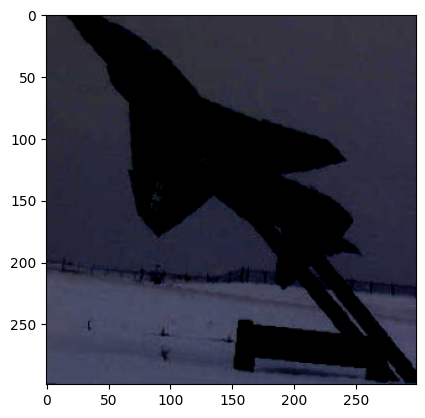

In [6]:
#visualize an image from train_dataset

i = 1135

image = train_dataset[i][0].permute(1, 2, 0).numpy()
label = mapping[str(train_dataset[i][1]+1)] #+1 is required, because the "class 1" in folders, is class 0 when torch loads it

print(f"label: {label} (index - {train_dataset[i][1]+1})")
plt.imshow(image)

In [8]:

model = ResNet(
    block=BottleNeck,
    layers=[2, 2, 2, 2],

    dropout=0.5
)

model.load_state_dict(torch.load("resnet26_scratch_implementation_weights.pth"))


model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)

In [9]:
import torch

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

trainable_params = count_trainable_parameters(model)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 14470720


In [ ]:
print_test_details(model, criterion, test_loader)


In [11]:
for epoch in range(10):

    start = time.time()
    iteration_state = time.time()
    total_training_loss = 0
    total_training_samples = 0
    total_training_correct_classfied = 0

    model.train()

    for iteration, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        output_predictions = model(images)

        loss_value = criterion(output_predictions, labels)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        

        
        total_training_loss += loss_value.item()*labels.shape[0]
        total_training_samples += labels.shape[0]
        _, predicted = torch.max(output_predictions, dim=1)
        total_training_correct_classfied += (labels == predicted).sum().item()

        if iteration%250==0:
            print(f"iteration {iteration+1} done., time={time.time()-iteration_state}")
            iteration_state = time.time()

    print(f"epoch: {epoch+1}, train loss: {total_training_loss/total_training_samples}, train accuracy: {total_training_correct_classfied/total_training_samples}, time taken: {time.time()-start}")

    # if (epoch-1)%3==0:
    #     print_test_details(model, criterion, test_loader)   
    print()





iteration 1 done., time=9.351710796356201
iteration 251 done., time=2491.637362241745
epoch: 1, train loss: 2.0661259155452774, train accuracy: 0.5108294157152451, time taken: 3695.4498472213745

iteration 1 done., time=9.894910335540771
iteration 251 done., time=2461.6044921875
epoch: 2, train loss: 1.9914637774409185, train accuracy: 0.5244291470785762, time taken: 3701.982902765274

iteration 1 done., time=10.082135438919067


KeyboardInterrupt: 

In [12]:
torch.save(model.state_dict(), "resnet26_scratch_implementation_weights.pth")

In [ ]:
device